In [5]:
import os
import cv2
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn.functional as F
from network import AttU_Net

# change path at libs
new_working_directory = 'C:/Users/JKKY/Desktop/project_dacon/hrnet_init' # 작업경로
os.chdir(new_working_directory)
print(os.getcwd())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


if torch.cuda.is_available():
    # CUDA가 사용 가능한 경우
    device = torch.device("cuda")
    print("You have a GPU with CUDA enabled.")
    print("GPU in use:", torch.cuda.get_device_name(0))
else:
    # CUDA가 사용 불가능한 경우
    device = torch.device("cpu")
    print("Cuda currently cannot use GPU, I will use CPU")

C:\Users\JKKY\Desktop\project_dacon\hrnet_init
You have a GPU with CUDA enabled.
GPU in use: NVIDIA GeForce RTX 2070 SUPER


In [6]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
################################################수정된 부분##################################################
#############################################################################################################
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, make_boundary=False): #make_boundary인자 추가
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.make_boundary = make_boundary

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))
        
        if self.make_boundary:
            # 바운더리 마스크 계산
            boundary_mask = self.calculate_boundary_mask(mask)

            # 바운더리 이미지맵 계산
            boundary_image = self.calculate_boundary_image(image, boundary_mask)        
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
            if self.make_boundary:
                augmented_boundary = self.transform(image=boundary_image, mask=boundary_mask)
                boundary_image = augmented_boundary['image']
                boundary_mask = augmented_boundary['mask']

        if self.make_boundary:
            return image, mask, boundary_image, boundary_mask
        else:
            return image, mask

    def calculate_boundary_mask(self, mask):
        kernel = np.ones((3, 3), np.uint8)
        if isinstance(mask, torch.Tensor):
            mask_np = mask.numpy().astype(np.uint8)
        else:
            mask_np = mask.astype(np.uint8)
        boundary_mask = cv2.erode(mask_np, kernel, iterations=2)
        boundary_mask = mask_np - boundary_mask
        return boundary_mask

    def calculate_boundary_image(self, image, boundary_mask):
        boundary_image = np.copy(image)
        # 바운더리는 빨간색으로 표시 (빨간색: [255, 0, 0])
        boundary_image[boundary_mask > 0, 0] = 255
        boundary_image[boundary_mask > 0, 1] = 0
        boundary_image[boundary_mask > 0, 2] = 0
        return boundary_image
################################################수정된 부분##################################################
#############################################################################################################

In [4]:
####잘 리턴 되는지 확인####

test_dataset = SatelliteDataset(csv_file='C:/Users/JKKY/Desktop/project_dacon/hrnet_init/train.csv', #본인 경로
                                transform=None,
                                make_boundary=True)

# 테스트 데이터셋에서 첫 번째 데이터를 가져옴
image, mask, boundary_image, boundary_mask = test_dataset[1]

# boundary_mask의 shape과 dtype 출력
print(image.shape)
print(image.dtype)
print(mask.shape)
print(mask.dtype)

print('------------')
print(boundary_image.shape)
print(boundary_image.dtype)
print(boundary_mask.shape)
print(boundary_mask.dtype)

print('shape과 dtype')

(1024, 1024, 3)
uint8
(1024, 1024)
uint8
------------
(1024, 1024, 3)
uint8
(1024, 1024)
uint8


In [10]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=0)

for i_n, m_n, i_b, m_b in dataloader:
    print(i_n.shape) # 일반 이미지
    print(m_n.shape) # 일반 마스크
    print(i_b.shape) # 바운더리 이미지
    print(m_b.shape) # 바운더리 마스크
    break

torch.Size([16, 1024, 1024, 3])
torch.Size([16, 1024, 1024])
torch.Size([16, 1024, 1024, 3])
torch.Size([16, 1024, 1024])


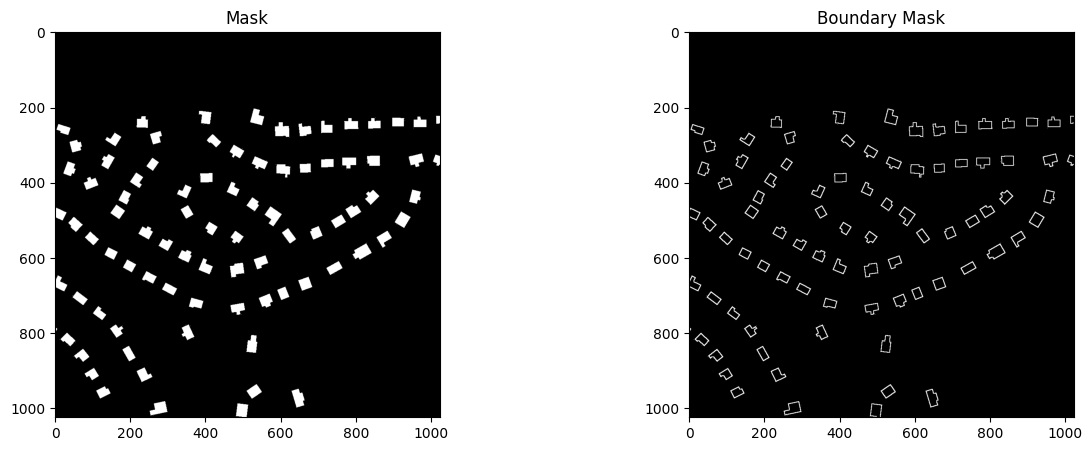

In [11]:
###########시각화 테스트 : 마스크##########

import matplotlib.pyplot as plt

def plot_masks(image, mask, boundary_mask):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot original mask
    axes[0].imshow(mask, cmap='gray')
    axes[0].set_title("Mask")
    
    # Plot boundary mask
    axes[1].imshow(boundary_mask, cmap='gray')
    axes[1].set_title("Boundary Mask")
    
    plt.show()

# Visualize the masks and boundary masks
plot_masks(image, mask, boundary_mask)

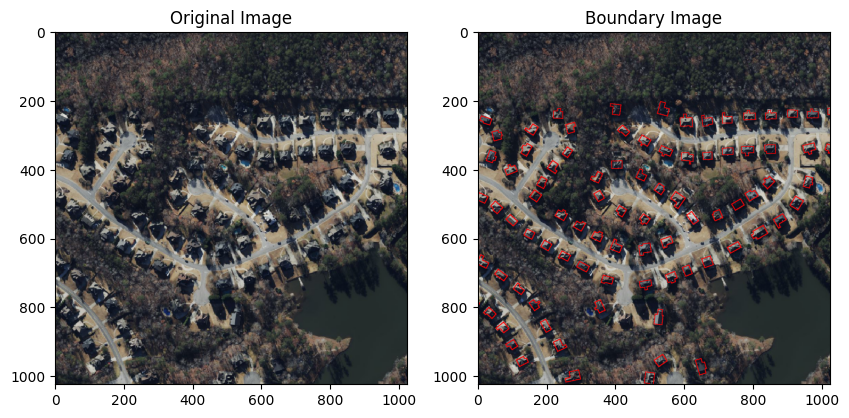

In [12]:
###########시각화 테스트 : 이미지##########
try:
    image_np = image.numpy()
    boundary_image_np = boundary_image.numpy()

    # 이미지 시각화
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(image_np, (1, 2, 0)))  # (3, 224, 224) -> (224, 224, 3)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(boundary_image_np, (1, 2, 0)))  # (3, 224, 224) -> (224, 224, 3)
    plt.title('Boundary Image')

    plt.show()
except:
    # 이미지 시각화
    plt.figure(figsize=(10, 5))

    # 원본 이미지 시각화
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    # 바운더리 이미지 시각화
    plt.subplot(1, 2, 2)
    plt.imshow(boundary_image)
    plt.title("Boundary Image")

    plt.show()